In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

Problem Statement: Data with health care attributes and other personal details to classify if the person gets stroke or not based on their health atrributes

# Data Loading and Analysis


In [2]:
data = pd.read_csv('healthcare-dataset.csv')
data.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


** Few Early Observations**

1. There are 3 binary featuers - {hypertension,heart_disease,stroke'}
2. There are 2 numerical Features which needs normalization('Bmi, glucose_level and age')
3. We need to convert categorical variables to numerical values.
4. Features are less. Need to create custom featurs.

In [4]:
#looking for some basic data discrepency
display(data.isnull().sum())
display(data.shape)

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

(5110, 12)

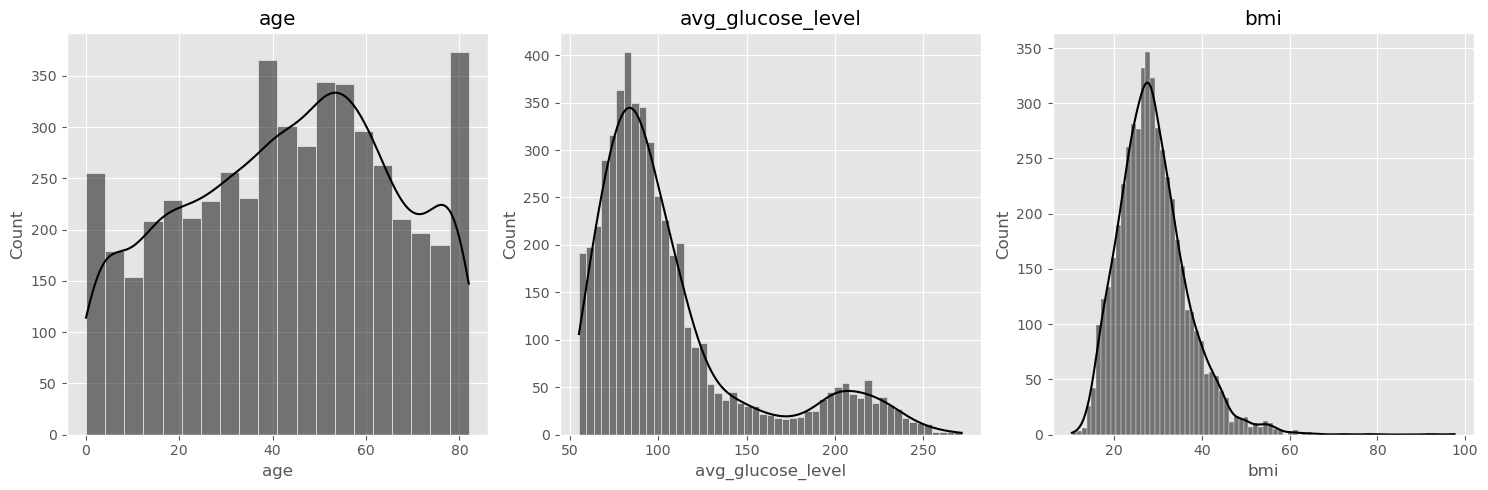

In [5]:
plt.style.use('ggplot')

plots = ['age', 'avg_glucose_level', 'bmi']

plt.figure(figsize=(15, 5))  # Adjust figsize to fit all plots comfortably

for i, column in enumerate(plots):
    plt.subplot(1, 3, i+1)
    sns.histplot(data[column], color='black', bins='auto', kde=True)
    plt.title(column)
    plt.grid(True)

plt.tight_layout()  
plt.show()


**The distribution of values of avg-glucose_level is not a normal distribution**

**avg_glucose_level seems to be skewed plus is multimodel distribution so MinMaxScaler and StandardScaler might not work here**

**No duplicate values in the data**

**For missing values in the BMI imputation, going to use  mean  value  for imputation as the distribution of the bmi data seems to be a normal distribution**

In [6]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

In [7]:
#1st impute/fill the missing values
#only BMI has missing values 
imputer = SimpleImputer(strategy = 'mean')
data['bmi']=imputer.fit_transform(data[['bmi']])
encoded_data= data.copy()
#2nd Scale down the numerical features
features_to_scale=['age','bmi']
scaler = MinMaxScaler()
encoded_data[features_to_scale]=scaler.fit_transform(encoded_data[features_to_scale])

In [8]:
#as the 'avg glucose level dosent have a normal distribution hence i am usign QuantileTransformer here 
from sklearn.preprocessing import QuantileTransformer

# Initialize QuantileTransformer
scaler = QuantileTransformer(output_distribution='uniform')

# Apply quantile transformation to avg_glucose_level
encoded_data['avg_glucose_level'] = scaler.fit_transform(encoded_data[['avg_glucose_level']])


In [9]:
df = encoded_data.copy()
df.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [10]:
# List of columns to one-hot encode
columns_to_encode = ['Residence_type', 'work_type', 'smoking_status','ever_married','gender']

# Iterate through each column and apply pd.get_dummies
for column in columns_to_encode:
    encoded_column = pd.get_dummies(df[column], prefix=column)
    df = pd.concat([df, encoded_column], axis=1)
    df = df.drop(columns=[column],axis=1)

# Convert boolean to integers
df = df.astype(int)


In [11]:
df.drop('id',axis=1,inplace=True)

**The data now has around 23 features **

**The dataframe 'df' now has clean data**

In [12]:
df.drop(['Residence_type_Rural','work_type_Private','smoking_status_Unknown', 'smoking_status_formerly smoked',
         'ever_married_Yes', 'gender_Male'], axis=1, inplace=True)

In [13]:
df.columns

Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi',
       'stroke', 'Residence_type_Urban', 'work_type_Govt_job',
       'work_type_Never_worked', 'work_type_Self-employed',
       'work_type_children', 'smoking_status_never smoked',
       'smoking_status_smokes', 'ever_married_No', 'gender_Female',
       'gender_Other'],
      dtype='object')

# Data Split

In [14]:
X = df.drop('stroke',axis=1)
y = df['stroke']
X_train,X_valid,y_train,y_valid = train_test_split(X,y,test_size = 0.2,random_state=42) 


# Model Selection

**Train Logistic Regression Classifier**

In [15]:
# Instantiate Logistic Regression model
logreg = LogisticRegression()

# Train the model
logreg.fit(X_train, y_train)


LogisticRegression()

Predict the model output

In [16]:

# Predict on validation set
y_pred = logreg.predict(X_valid)

# Calculate accuracy
accuracy = accuracy_score(y_valid, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9393346379647749
